#### Requirements
Using Python 3.11

**Necessary**
- Numpy 
- Pandas
- Matplotlib
- Beautiful Soup
- Seaborn (nice graphs)

_Might Need_
- Scipy
- Scikit-Learn
- tqdm (decoration) 

`pip install pandas seaborn scipy scikit-learn tqdm --no-cache-dir`


In [28]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import os
import csv
import random

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from scipy.stats import multivariate_normal


# Data

## Inspection

Just inspect it and decide which dataset to use and stuff

Viable Datasets
- [Traffic flow in Romanian cities during and around lifting of COVID19 restrictions](https://data.mendeley.com/datasets/g64s8h9k57/3)
- [New Delhi Traffic Probe & Analytics 2024](https://www.kaggle.com/datasets/rawsi18/new-delhi-traffic-probe-and-analytics-2024)

In [29]:
def cleanUnicode(s):
    s = s.replace(r"\u0163", "t")
    s = s.replace(r"\u015f", "s")
    s = s.replace(r"\u0219", "s")
    s = s.replace(r"\xe2", "a")
    s = s.replace(r"\u015e", "S")
    s = s.replace(r"\xf3k", "a")
    s = s.replace(r"\xe9", "e")
    s = s.replace(r"\u0103", "a")
    s = s.replace(r"\u0103", "a")
    return s


In [30]:
import glob
glob.glob("data/sample_data/*.xml")

['data/sample_data\\bacau_01-06-2020_0001.xml',
 'data/sample_data\\bacau_01-06-2020_0016.xml',
 'data/sample_data\\bacau_01-06-2020_0031.xml',
 'data/sample_data\\bacau_01-06-2020_0046.xml',
 'data/sample_data\\bacau_01-06-2020_0101.xml',
 'data/sample_data\\bacau_01-06-2020_0116.xml',
 'data/sample_data\\bacau_01-06-2020_0131.xml',
 'data/sample_data\\bacau_01-06-2020_0146.xml',
 'data/sample_data\\bacau_01-06-2020_0201.xml',
 'data/sample_data\\bacau_01-06-2020_0216.xml',
 'data/sample_data\\bacau_01-06-2020_0231.xml',
 'data/sample_data\\bacau_01-06-2020_0246.xml',
 'data/sample_data\\bacau_01-06-2020_0301.xml',
 'data/sample_data\\bacau_01-06-2020_0316.xml',
 'data/sample_data\\bacau_01-06-2020_0331.xml',
 'data/sample_data\\bacau_01-06-2020_0346.xml',
 'data/sample_data\\bacau_01-06-2020_0401.xml',
 'data/sample_data\\bacau_01-06-2020_0416.xml',
 'data/sample_data\\bacau_01-06-2020_0431.xml',
 'data/sample_data\\bacau_01-06-2020_0446.xml',
 'data/sample_data\\bacau_01-06-2020_050

In [31]:
def parse_data(folder_path):
    xml_files = glob.glob(os.path.join(folder_path, "*.xml"))
    rows = [["date", "time", "de", "le", "pc", "qd", "fc", "la", "lo", "cn", "ff", "jf", "sp", "su", "ty"]]
    
    for file in xml_files:
        file_name = os.path.basename(file)
        name_parts = file_name.replace(".xml", "").split("_")

        # Handle flexible filename formats
        try:
            city = name_parts[0]
            date = name_parts[1]

            # Extract time safely
            time_str = name_parts[2].replace("-", "").replace(".", "")
            time_val = ''.join([c for c in time_str if c.isdigit()])
            if time_val == "":
                time_val = "0"
            time = 5 * round(int(time_val) / 5)
        except IndexError:
            print(f" Skipping malformed filename: {file_name}")
            continue
        except ValueError:
            print(f"  Could not parse time from: {file_name}")
            continue

        with open(file, "r", encoding="utf-8") as f:
            content = f.read()

        soup = BeautifulSoup(content, "lxml")
        roads = soup.find_all("fi")

        for road in roads:
            tmc = road.find("tmc")
            shps = road.find_all("shp")
            cf = road.find("cf")
            
            de = le = pc = qd = fc = la = lo = cn = ff = jf = sp = su = ty = ""

            if tmc:
                de = tmc.get("de", "N/A")
                le = tmc.get("le", "-1")
                pc = tmc.get("pc", "-1")
                qd = tmc.get("qd", "")

            if shps:
                fc = 6
                coords = []
                for shp in shps:
                    fc = min(fc, int(shp.get("fc", 6)))
                    for p in shp.text.strip().split():
                        coords.append(tuple(map(float, p.split(','))))
                if coords:
                    la = sum(c[0] for c in coords) / len(coords)
                    lo = sum(c[1] for c in coords) / len(coords)
                else:
                    la = "N/A"
                    lo = "N/A"

            if cf:
                cn = cf.get("cn", "")
                ff = cf.get("ff", "")
                jf = cf.get("jf", "")
                sp = cf.get("sp", "")
                su = cf.get("su", "")
                ty = cf.get("ty", "")

            de = cleanUnicode(de)
            rows.append([date, time, de, le, pc, qd, fc, la, lo, cn, ff, jf, sp, su, ty])

    if rows:
        out_file = f"dump_{city}.csv"
        with open(out_file, "w", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)
            writer.writerows(rows)
        print(f" Data written to {out_file}")
    else:
        print(" No XML files processed.")



        
                
                


    

In [32]:
parse_data("data/sample_data")

 Data written to dump_bacau.csv


## Sanitization

We need it in .csv, in nice and tidy format. 

In [33]:
df = pd.read_csv("./dump_bacau.csv", encoding="utf-8")
df.columns  = df.columns.str.strip()

In [34]:
df["datetime"] = pd.to_datetime(
    df["date"].astype(str) + " " + df["time"].astype(str).str.zfill(4),
    format="%d-%m-%Y %H%M",
    errors="coerce"
)

df["road_id"] = df["pc"].astype(str) + "-" + df["qd"].apply(lambda x: "up" if x == "+" else "down")
df['hour'] = df['datetime'].dt.hour

clean_df = df.drop(["date", "time", "sp", "ty", "pc", "qd"], axis=1)


In [35]:
clean_df['road_id'].nunique()

373

In [36]:
clean_df.head()

,de,le,fc,la,lo,cn,ff,jf,su,datetime,road_id,hour
0,DN2,0.04634,1,46.539543,26.916972,0.73,31.5,0.00000,37.21,2020-06-01,3763-up,0
1,Strada Bucegi,0.08475,1,46.539415,26.916097,0.72,40.4,0.00000,43.22,2020-06-01,18042-up,0
2,Strada Victor Babes,0.20342,1,46.539133,26.914116,0.72,20.0,0.00000,19.71,2020-06-01,18041-up,0
3,Strada Aeroportului,0.45421,1,46.538463,26.909395,0.73,20.0,0.52823,15.79,2020-06-01,18040-up,0
4,Strada Alexei Tolstoi,0.70002,1,46.539362,26.904840,0.72,29.4,0.22033,28.66,2020-06-01,14603-up,0


In [37]:
hourly_agg_df =  clean_df.groupby(["road_id", "de", "le", "la", "lo", "hour"]).agg({
        "ff": "mean",
        "jf": "mean",
        "su": "mean"
    }).reset_index()

In [38]:
hourly_agg_df.head(30)

,road_id,de,le,la,lo,hour,ff,jf,su
0,13639-down,Calea Marasesti,0.50153,46.557819,26.911716,0,46.9,0.496862,44.2200
1,13639-down,Calea Marasesti,0.50153,46.557819,26.911716,1,46.9,1.018533,40.6550
2,13639-down,Calea Marasesti,0.50153,46.557819,26.911716,2,46.9,0.166860,46.0000
3,13639-down,Calea Marasesti,0.50153,46.557819,26.911716,3,46.9,1.329483,38.9800
4,13639-down,Calea Marasesti,0.50153,46.557819,26.911716,4,46.9,1.078993,42.1425
5,13639-down,Calea Marasesti,0.50153,46.557819,26.911716,5,46.9,1.284973,39.2200
6,13639-down,Calea Marasesti,0.50153,46.557819,26.911716,6,46.9,0.753665,43.2425
7,13639-down,Calea Marasesti,0.50153,46.557819,26.911716,7,46.9,2.153598,33.7850
8,13639-down,Calea Marasesti,0.50153,46.557819,26.911716,8,46.9,2.610873,30.5700
9,13639-down,Calea Marasesti,0.50153,46.557819,26.911716,9,46.9,3.019057,28.3675


In [39]:
fin_df = hourly_agg_df.pivot_table(
        index=["road_id", "de", "le", "ff"],
        columns="hour",
        values=["jf", "su"])

In [40]:
fin_df.columns = [f"{var}_{hour}" for var, hour in fin_df.columns]
fin_df = fin_df.reset_index()

In [41]:
fin_df.head(10)

,road_id,de,le,ff,jf_0,jf_1,jf_2,jf_3,jf_4,jf_5,...,su_14,su_15,su_16,su_17,su_18,su_19,su_20,su_21,su_22,su_23
0,13639-down,Calea Marasesti,0.50153,46.9,0.496862,1.018533,0.166860,1.329483,1.078993,1.284973,...,32.8950,30.3400,39.7925,33.4825,34.9625,41.8275,32.8750,43.1250,47.1500,45.2800
1,13639-up,Calea Marasesti,0.57544,43.3,0.060240,0.060240,0.030120,0.763127,1.100038,2.163810,...,24.6250,21.7925,32.0650,26.2000,30.1525,40.0475,41.9125,48.6100,43.0000,38.8000
2,13640-down,Strada Ionita Sandu Sturza,0.57544,42.5,0.102300,0.213130,0.102300,0.094090,1.789005,1.237302,...,22.5775,23.4200,27.3725,25.1025,24.1025,39.8000,39.3150,41.3725,42.0000,40.3900
3,13640-up,Strada Ionita Sandu Sturza,0.43693,43.2,0.040250,0.040250,0.191218,0.569725,1.171325,0.964165,...,20.0650,28.2150,34.8825,30.3425,33.3025,40.2575,40.9850,42.7050,42.0000,37.4600
4,13641-down,DN2G,0.45878,39.4,0.088280,0.074978,0.047745,0.692070,1.590383,0.643452,...,20.2200,22.5775,27.9400,19.0750,30.0150,35.0000,38.5250,38.8950,38.2375,34.9100
5,13641-up,DN2G,0.39176,38.5,0.112930,0.066433,0.105152,0.463010,1.282075,1.240585,...,24.4175,19.6225,24.8650,24.6900,27.3725,33.8125,35.2625,40.3775,37.1350,36.8725
6,13642-down,DN15,0.33088,39.6,0.058690,0.120457,0.186805,1.986130,1.334963,2.372248,...,17.5725,20.4325,19.5000,26.3100,29.9725,37.0650,39.3350,39.2575,39.3400,39.0100
7,13642-up,DN15,0.52862,44.2,0.000000,0.000000,0.155277,2.353575,2.875167,2.212077,...,23.5075,25.4075,34.4175,34.1275,42.7450,41.4975,39.7350,44.1000,42.2575,41.6575
8,13643-down,Strada I. L. Caragiale,0.54963,44.8,0.049232,0.000000,0.124367,2.068763,2.825520,2.751215,...,24.0675,28.7875,33.2100,38.0500,40.3275,44.3025,45.6150,43.5925,45.0450,41.5000
9,13643-up,Strada I. L. Caragiale,0.78983,48.1,0.185713,0.031227,0.000000,0.345540,0.000000,0.431410,...,45.7350,45.8375,48.4500,51.7175,48.8225,48.0725,50.6150,49.2575,45.6500,47.1125


In [42]:
fin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 52 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   road_id  373 non-null    object 
 1   de       373 non-null    object 
 2   le       373 non-null    float64
 3   ff       373 non-null    float64
 4   jf_0     373 non-null    float64
 5   jf_1     373 non-null    float64
 6   jf_2     373 non-null    float64
 7   jf_3     373 non-null    float64
 8   jf_4     373 non-null    float64
 9   jf_5     373 non-null    float64
 10  jf_6     373 non-null    float64
 11  jf_7     373 non-null    float64
 12  jf_8     373 non-null    float64
 13  jf_9     373 non-null    float64
 14  jf_10    373 non-null    float64
 15  jf_11    373 non-null    float64
 16  jf_12    373 non-null    float64
 17  jf_13    373 non-null    float64
 18  jf_14    373 non-null    float64
 19  jf_15    373 non-null    float64
 20  jf_16    373 non-null    float64
 21  jf_17    373 non

## Preprocessing


In [43]:
# Imputing
features_to_scale = fin_df.columns[3:]
fin_df[features_to_scale] = fin_df[features_to_scale].apply(pd.to_numeric, errors = 'coerce')
imputer = SimpleImputer(strategy='mean')
fin_df[features_to_scale] = imputer.fit_transform(fin_df[features_to_scale])


In [44]:
# Standardizing
scaler = StandardScaler()
fin_df[features_to_scale] = scaler.fit_transform(fin_df[features_to_scale])

In [23]:
fin_df.head()

,road_id,de,le,ff,jf_0,jf_1,jf_2,jf_3,jf_4,jf_5,...,su_14,su_15,su_16,su_17,su_18,su_19,su_20,su_21,su_22,su_23
0,13639-down,Calea Marasesti,0.50153,0.552101,1.504781,3.139660,-0.218369,1.116117,0.093236,0.151847,...,-0.210439,-0.471887,0.242351,-0.379496,-0.348064,0.195706,-0.735984,0.203667,0.561328,0.403959
1,13639-up,Calea Marasesti,0.57544,0.182842,-0.473606,-0.499689,-0.589388,0.264187,0.115558,1.009734,...,-0.864002,-1.135863,-0.384660,-0.956781,-0.756331,0.037269,0.083514,0.713522,0.175858,-0.188895
2,13640-down,Strada Ionita Sandu Sturza,0.57544,0.100785,-0.283027,0.080948,-0.393541,-0.742201,0.846327,0.105313,...,-1.025812,-1.009438,-0.765411,-1.043780,-1.269848,0.015239,-0.152021,0.040765,0.082974,-0.043426
3,13640-up,Strada Ionita Sandu Sturza,0.43693,0.172585,-0.564183,-0.575606,-0.152280,-0.026736,0.191171,-0.161313,...,-1.224370,-0.636959,-0.156048,-0.628404,-0.488963,0.055961,-0.000590,0.164627,0.082974,-0.311492
4,13641-down,DN2G,0.45878,-0.217189,-0.346553,-0.443720,-0.541565,0.157300,0.635654,-0.474381,...,-1.212121,-1.074884,-0.719364,-1.521582,-0.768002,-0.412008,-0.223656,-0.189530,-0.266503,-0.544791


# Algorithm

In [45]:
def gmm(X: np.ndarray, max_iter:int, n_clusters:int, seed:int = 0):
    n,d = X.shape
    k = n_clusters
    # np.random.seed(seed)
    c_pi = (1/k)*np.ones(k)
    c_mu = np.random.default_rng((d,k))
    c_sigma = np.array([np.eye(d) for i in range(k)])

    for i in range(max_iter):
        # E step
        cp_resp = np.zeros(n,k)
        



    

In [37]:
X = np.array([[1,2,3],[4,5,6], [7,8,9], [10, 11, 12], [13,14,15]])
k = np.array([[1,1,1], [2,2,2]])

X[:,None, :] - k[None, :, :]

array([[[ 0,  1,  2],
        [-1,  0,  1]],

       [[ 3,  4,  5],
        [ 2,  3,  4]],

       [[ 6,  7,  8],
        [ 5,  6,  7]],

       [[ 9, 10, 11],
        [ 8,  9, 10]],

       [[12, 13, 14],
        [11, 12, 13]]])

In [46]:
# Algorithm Implementation
X = fin_df.iloc[:, 4:].to_numpy()
print("Feature matrix shape:", X.shape)

Feature matrix shape: (373, 48)


In [64]:
def gmm(X: np.ndarray, max_iter: int, n_clusters: int, seed: int = 0):
    """
    Gaussian Mixture Model (EM algorithm)
    Args:
        X : (n, d) ndarray (standardized data)
        max_iter : number of iterations
        n_clusters : number of Gaussian components
        seed : random seed
    Returns:
        c_pi : (k,) mixture weights
        c_mu : (k, d) means
        c_sigma : (k, d, d) covariances
        resp : (n, k) responsibilities
    """
    n, d = X.shape
    k = n_clusters
    rng = np.random.default_rng(seed)

    # --- Initialization ---
    c_pi = np.ones(k) / k
    # c_mu = rng.normal(size=(k, d))   # from N(0,1)
    init_idx = np.random.choice(len(X), 3, replace=False)
    c_mu = X[init_idx]
    c_sigma = np.array([np.eye(d) for _ in range(k)])

    # --- EM Loop ---
    for _ in range(max_iter):
        # ----- E-step -----
        resp = np.zeros((n, k))
        for j in range(k):
            resp[:, j] = c_pi[j] * multivariate_normal(
                mean=c_mu[j], cov=c_sigma[j], allow_singular=True
            ).pdf(X)

        # normalize responsibilities
        resp_sum = resp.sum(axis=1, keepdims=True)
        resp_sum[resp_sum == 0] = 1e-15
        resp /= resp_sum

        # ----- M-step -----
        N_k = resp.sum(axis=0)  # (k,)

        # update means
        c_mu = np.einsum('nk,nd->kd', resp, X) / N_k[:, None]

        # update covariances
        c_sigma = np.zeros((k, d, d))
        for j in range(k):
            X_centered = X - c_mu[j]
            c_sigma[j] = np.einsum('n,ni,nj->ij', resp[:, j], X_centered, X_centered) / N_k[j]
            c_sigma[j] += np.eye(d) * 1e-6  # numerical stability

        # update weights
        c_pi = N_k / n

    return c_pi, c_mu, c_sigma, resp


In [65]:
# Running GMM
c_pi, c_mu, c_sigma, resp = gmm(X, max_iter=200, n_clusters=3, seed=42)

# Assign each data point to its most likely cluster
cluster_labels = np.argmax(resp, axis=1)

fin_df["cluster"] = cluster_labels
print(fin_df["cluster"].value_counts())


cluster
1    142
2    120
0    111
Name: count, dtype: int64


# Graphs and Interpretations and stuff

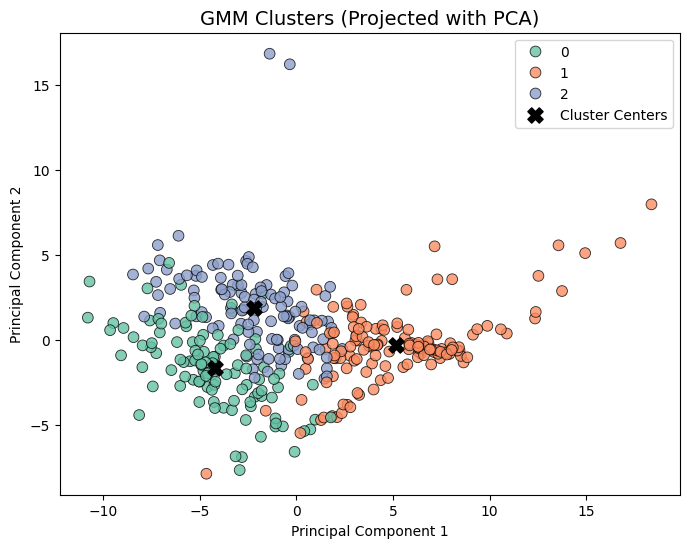

In [66]:
# Visualizing the clusters
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

pca_df = pd.DataFrame(X_2d, columns=['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_df, x='PC1', y='PC2', hue='Cluster',
    palette='Set2', s=60, edgecolor='k', alpha=0.8
)
plt.title("GMM Clusters (Projected with PCA)", fontsize=14)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Mark cluster centers (based on PCA projection)
centers = pca_df.groupby('Cluster')[['PC1', 'PC2']].mean()
plt.scatter(centers['PC1'], centers['PC2'], c='black', s=120, marker='X', label='Cluster Centers')

plt.legend()
plt.show()


In [57]:
# from matplotlib.patches import Ellipse

# def draw_ellipse(position, covariance, ax=None, **kwargs):
#     ax = ax or plt.gca()
#     if covariance.shape == (2, 2):
#         U, s, Vt = np.linalg.svd(covariance)
#         angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
#         width, height = 2 * np.sqrt(s)
#     else:
#         angle, width, height = 0, 2 * np.sqrt(covariance)
#     for nsig in range(1, 4):
#         ax.add_patch(Ellipse(xy=position, 
#                              width=nsig * width, 
#                              height=nsig * height,
#                              angle=angle, 
#                              alpha=0.15, **kwargs))

# # Plot clusters + ellipses
# fig, ax = plt.subplots(figsize=(8,6))
# sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=pca_df['Cluster'], palette='Set2', ax=ax)

# for i in range(len(c_pi)):
#     draw_ellipse(c_mu[i, :2], c_sigma[i][:2, :2], ax=ax, color=sns.color_palette('Set2')[i])

# plt.title("Custom GMM Cluster Ellipses (PCA Projection)", fontsize=14)
# plt.xlabel("Principal Component 1")
# plt.ylabel("Principal Component 2")
# plt.legend()
# plt.show()


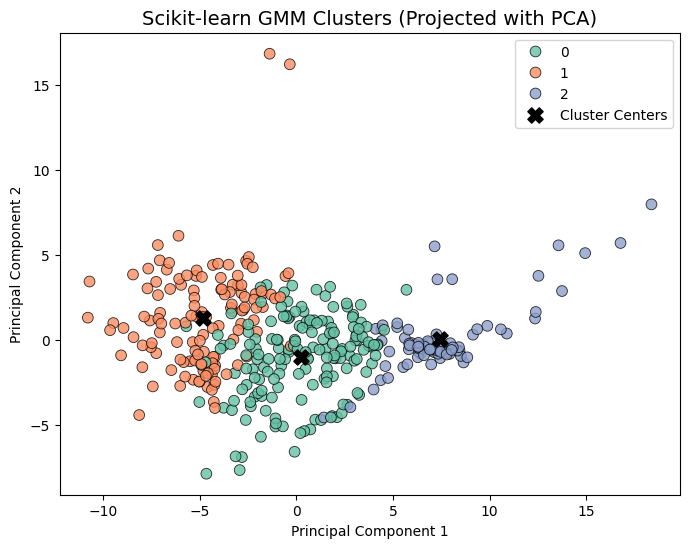

In [67]:
# Comparing with Scikitt-Learn
from sklearn.mixture import GaussianMixture

# Choose number of clusters (same as your custom GMM)
n_clusters = 3  

gmm_sklearn = GaussianMixture(
    n_components=n_clusters,
    covariance_type='full',   # matches your manual version
    max_iter=200,
    random_state=42
)
gmm_sklearn.fit(X)

# Predict cluster assignments and probabilities
labels_sklearn = gmm_sklearn.predict(X)
probs_sklearn = gmm_sklearn.predict_proba(X)

pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X)

pca_df_sklearn = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df_sklearn['Cluster'] = labels_sklearn

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_df_sklearn, x='PC1', y='PC2',
    hue='Cluster', palette='Set2', s=60, edgecolor='k', alpha=0.8
)
plt.title("Scikit-learn GMM Clusters (Projected with PCA)", fontsize=14)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Mark cluster centers
centers = pca_df_sklearn.groupby('Cluster')[['PC1','PC2']].mean()
plt.scatter(centers['PC1'], centers['PC2'], c='black', s=120, marker='X', label='Cluster Centers')

plt.legend()
plt.show()

In [68]:
# Cluster consistency
from sklearn.metrics import adjusted_rand_score

score = adjusted_rand_score(cluster_labels, labels_sklearn)
print(f"Adjusted Rand Index between Custom GMM and sklearn GMM: {score:.4f}")

Adjusted Rand Index between Custom GMM and sklearn GMM: 0.2121


In [69]:
# Mixing Parameters
print("Custom GMM means:\n", c_mu)
print("\nSklearn GMM means:\n", gmm_sklearn.means_)


Custom GMM means:
 [[ 0.14050359  0.22228591  0.35091243  0.18018773  0.15741917  0.29445408
   0.1848792   0.1811341   0.13834591  0.14566283  0.09549313  0.17411984
   0.18893588  0.13988364  0.16937665  0.28172371  0.27305882  0.18240056
   0.37384556  0.28740015  0.2946293  -0.01223701  0.14853559 -0.02431893
  -1.02321542 -1.03007157 -1.02915579 -0.94511387 -0.86578083 -0.89677861
  -0.78024694 -0.80098591 -0.77121165 -0.75069886 -0.75616626 -0.79232273
  -0.79281008 -0.78516194 -0.81053293 -0.87576927 -0.91617309 -0.88042335
  -0.99355183 -1.00900836 -1.0538415  -0.99633295 -1.02855171 -0.99836047]
 [-0.13025417 -0.19507898 -0.34490682 -0.50744956 -0.61134505 -0.66774244
  -0.71638882 -0.64981562 -0.70934173 -0.7117236  -0.71296635 -0.70114752
  -0.70070805 -0.70615892 -0.70591722 -0.72085142 -0.67119331 -0.70084034
  -0.55098683 -0.48875316 -0.24161744 -0.1638192  -0.09424608 -0.1871249
   0.7213745   0.74255135  0.76415453  0.85709015  0.95212018  0.94485101
   0.94638629  0.93

In [70]:
# log-likelihood comparison
log_likelihood_custom = np.sum(np.log(np.sum(resp, axis=1)))  # approximate
log_likelihood_sklearn = gmm_sklearn.score(X) * len(X)
print(f"Custom GMM log-likelihood: {log_likelihood_custom:.2f}")
print(f"Sklearn GMM log-likelihood: {log_likelihood_sklearn:.2f}")



Custom GMM log-likelihood: -0.00
Sklearn GMM log-likelihood: -1564.87


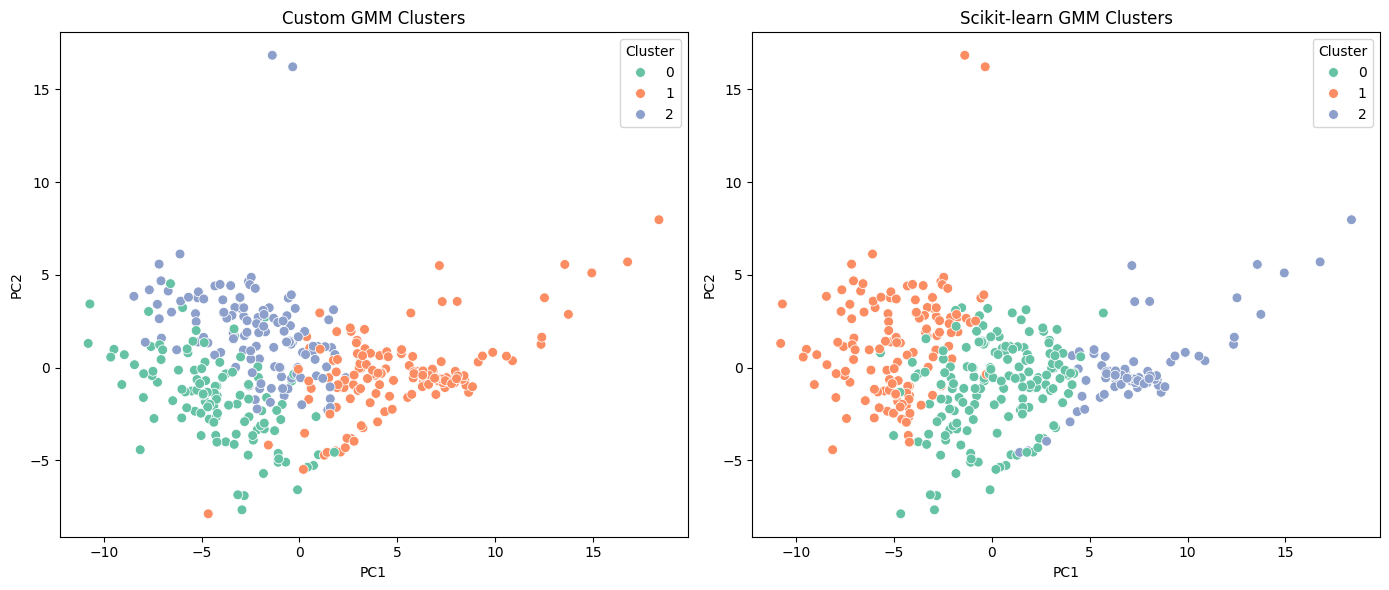

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Custom GMM
sns.scatterplot(
    data=pca_df, x='PC1', y='PC2',
    hue='Cluster', palette='Set2', s=50, ax=axes[0]
)
axes[0].set_title("Custom GMM Clusters")

# Sklearn GMM
sns.scatterplot(
    data=pca_df_sklearn, x='PC1', y='PC2',
    hue='Cluster', palette='Set2', s=50, ax=axes[1]
)
axes[1].set_title("Scikit-learn GMM Clusters")

plt.tight_layout()
plt.show()


Best seed: 46  Final Log-likelihood: -1241.9765
Adjusted Rand Index: 0.9295


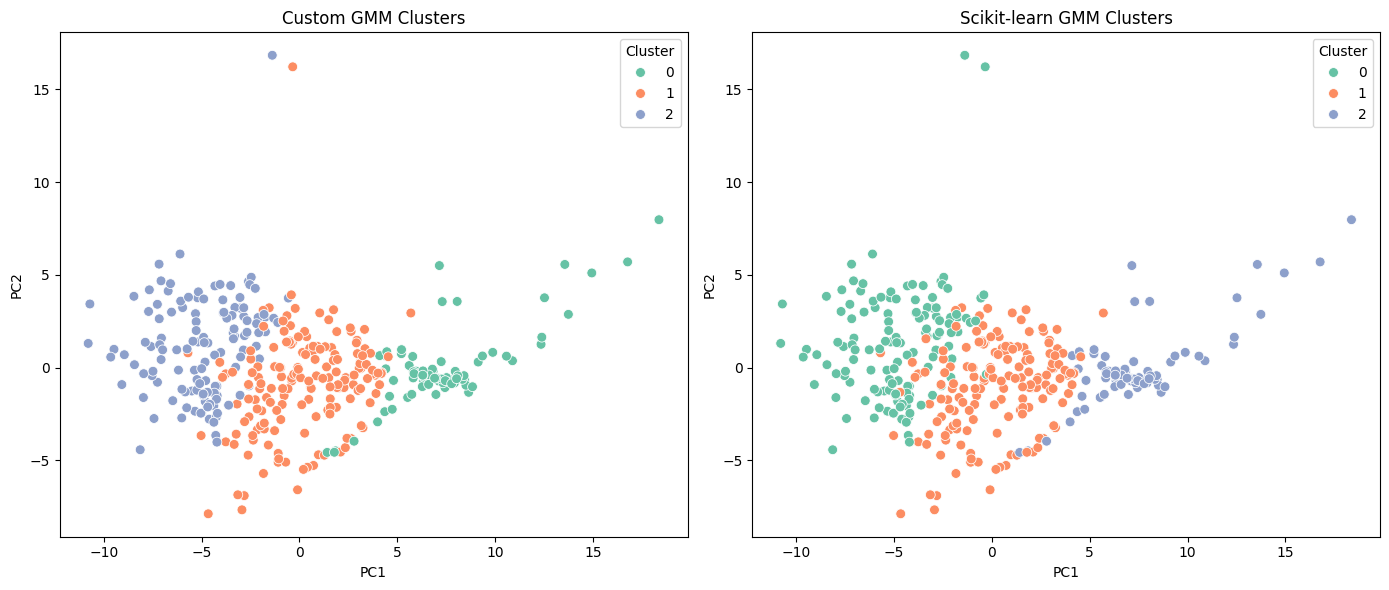

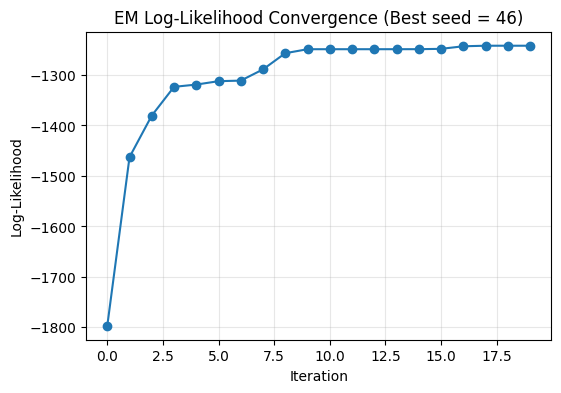

In [78]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
from scipy.stats import multivariate_normal

def gmm1(
    X: np.ndarray,
    max_iter: int = 200,
    n_clusters: int = 3,
    seed: int = 0,
    tol: float = 1e-4,
    reg_covar: float = 1e-6,
    init_with_kmeans: bool = True
):
    """
    Improved GMM (EM) with:
      - KMeans initialization (optional)
      - covariance regularization
      - log-likelihood monitoring and tolerance-based convergence
    """
    rng = np.random.default_rng(seed)
    n, d = X.shape
    k = n_clusters
    log_likelihoods = []

    # --- Initialization ---
    if init_with_kmeans:
        km = KMeans(n_clusters=k, random_state=seed, n_init=10).fit(X)
        c_mu = km.cluster_centers_.astype(float)
        c_sigma = np.zeros((k, d, d))
        c_pi = np.zeros(k)
        for j in range(k):
            members = X[km.labels_ == j]
            c_pi[j] = max(1, len(members))
            if len(members) > 1:
                c_sigma[j] = np.cov(members, rowvar=False)
            else:
                c_sigma[j] = np.cov(X, rowvar=False)
        c_pi /= c_pi.sum()
    else:
        c_pi = np.ones(k) / k
        c_mu = rng.normal(loc=0.0, scale=1.0, size=(k, d))
        c_sigma = np.array([np.cov(X, rowvar=False) + np.eye(d)*reg_covar for _ in range(k)])

    for j in range(k):
        c_sigma[j] += np.eye(d) * reg_covar

    prev_ll = -np.inf
    for it in range(max_iter):
        # ----- E-step -----
        weighted_pdfs = np.zeros((n, k))
        for j in range(k):
            try:
                pdf_vals = multivariate_normal(mean=c_mu[j], cov=c_sigma[j], allow_singular=True).pdf(X)
            except np.linalg.LinAlgError:
                c_sigma[j] += np.eye(d) * (reg_covar * 10)
                pdf_vals = multivariate_normal(mean=c_mu[j], cov=c_sigma[j], allow_singular=True).pdf(X)
            weighted_pdfs[:, j] = c_pi[j] * pdf_vals

        resp_denom = weighted_pdfs.sum(axis=1, keepdims=True)
        resp = weighted_pdfs / (resp_denom + 1e-15)

        # log-likelihood
        log_likelihood = np.sum(np.log(weighted_pdfs.sum(axis=1) + 1e-15))
        log_likelihoods.append(log_likelihood)

        if np.abs(log_likelihood - prev_ll) < tol:
            break
        prev_ll = log_likelihood

        # ----- M-step -----
        N_k = resp.sum(axis=0)
        N_k[N_k == 0] = 1e-8
        c_mu = (resp.T @ X) / N_k[:, None]

        c_sigma = np.zeros((k, d, d))
        for j in range(k):
            X_centered = X - c_mu[j]
            r = resp[:, j][:, None]
            c_sigma[j] = (X_centered * r).T @ X_centered / N_k[j]
            c_sigma[j] += np.eye(d) * reg_covar

        c_pi = N_k / n

    return c_pi, c_mu, c_sigma, resp, log_likelihoods

# ---------------------------
# Multiple restarts
# ---------------------------
best_ll = -np.inf
best_solution = None

for restart in range(5):
    seed = 42 + restart
    c_pi, c_mu, c_sigma, resp, log_likelihoods = gmm1(
        X,
        max_iter=300,
        n_clusters=3,
        seed=seed,
        tol=1e-5,
        reg_covar=1e-6,
        init_with_kmeans=True
    )
    if log_likelihoods[-1] > best_ll:
        best_ll = log_likelihoods[-1]
        best_solution = (c_pi, c_mu, c_sigma, resp, log_likelihoods, seed)

c_pi, c_mu, c_sigma, resp, log_likelihoods, best_seed = best_solution
cluster_labels_custom = np.argmax(resp, axis=1)
print(f"Best seed: {best_seed}  Final Log-likelihood: {best_ll:.4f}")

pca_df1 = pd.DataFrame(X_2d, columns=['PC1', 'PC2'])
pca_df1['Cluster'] = cluster_labels_custom

# sklearn GMM for comparison
gmm_sklearn1 = GaussianMixture(n_components=3, covariance_type='full', random_state=best_seed, n_init=5)
gmm_sklearn1.fit(X)
labels_sklearn1 = gmm_sklearn1.predict(X)

pca_df_sklearn1 = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df_sklearn1['Cluster'] = labels_sklearn1
# ARI
ari = adjusted_rand_score(cluster_labels_custom, labels_sklearn)
print(f"Adjusted Rand Index: {ari:.4f}")

# ---------------------------
# Visualization
# ---------------------------
# PCA projections already computed -> pca_df, pca_df_sklearn
fig, axes = plt.subplots(1, 2, figsize=(14,6))
sns.scatterplot(data=pca_df1, x='PC1', y='PC2', hue='Cluster', palette='Set2', s=50, ax=axes[0])
axes[0].set_title("Custom GMM Clusters")

sns.scatterplot(data=pca_df_sklearn1, x='PC1', y='PC2', hue='Cluster', palette='Set2', s=50, ax=axes[1])
axes[1].set_title("Scikit-learn GMM Clusters")

plt.tight_layout()
plt.show()

# Log-likelihood curve
plt.figure(figsize=(6,4))
plt.plot(log_likelihoods, marker='o')
plt.title(f"EM Log-Likelihood Convergence (Best seed = {best_seed})")
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.grid(True, alpha=0.3)
plt.show()
